In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import shap

In [2]:
data = pd.read_csv('cleantraining.csv')

In [3]:
UnrankedGames = pd.read_csv('cleantesting.csv')
UnrankedGames =UnrankedGames.reindex(columns=data.columns)
UnrankedX = UnrankedGames.drop(['id','bayesaverage','name','descriptions','mechanics','categories'], axis=1)

In [4]:
y=data['bayesaverage']
X=data.drop(['id','bayesaverage','name','descriptions','mechanics','categories'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3585)

##### Lasso Regresion

In [5]:
pipeLasso = Pipeline([
    ('scale', StandardScaler()),
    ('model', LassoCV()) #already cross validated
])

In [6]:
pipeLasso.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()), ('model', LassoCV())])

In [7]:
yhat=pipeLasso.predict(X_test)
np.sqrt(mean_squared_error(y_test,yhat))

0.4634214877221356

##### Random Forest

In [9]:
RFpipe = Pipeline([
    ('model', RandomForestRegressor())
])
params = {
  'model__n_estimators':tuple(range(50,751,50)), 
  'model__max_features':('sqrt', 'log2', None),
  'model__max_depth' : tuple(list(range(5, 101,5))+[None])
}

RFrs=RandomizedSearchCV(RFpipe, param_distributions=params,
                scoring = 'neg_mean_squared_error', cv=10)
RFrs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor())]),
                   param_distributions={'model__max_depth': (5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100, None),
                                        'model__max_features': ('sqrt', 'log2',
                                                                None),
                                        'model__n_estimators': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500, 550, 600,
                                                                650, 700,
                                                                750)},
                   scoring='neg_mean_squared_error')

Need to make new mod for Shap later

In [34]:
RFrs.best_params_

{'model__n_estimators': 500,
 'model__max_features': None,
 'model__max_depth': 30}

In [35]:
RFmod=RandomForestRegressor(n_estimators=500, max_depth=30)
RFmod.fit(X_train,y_train)

RandomForestRegressor(max_depth=30, n_estimators=500)

In [36]:
yhat=RFmod.predict(X_test)
np.sqrt(mean_squared_error(y_test,yhat))

0.42348285027989296

##### KNN

In [21]:
pipeknn = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', KNeighborsRegressor())
])
params = { 
  'poly__degree':(1,2),
  'model__n_neighbors' : tuple(range(5, 101,5)),
  'model__weights' : ('uniform', 'distance')
}
KNNrs=RandomizedSearchCV(pipeknn, param_distributions=params,
                scoring = 'neg_mean_squared_error', cv=10)
KNNrs.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('poly', PolynomialFeatures()),
                                             ('model', KNeighborsRegressor())]),
                   param_distributions={'model__n_neighbors': (5, 10, 15, 20,
                                                               25, 30, 35, 40,
                                                               45, 50, 55, 60,
                                                               65, 70, 75, 80,
                                                               85, 90, 95,
                                                               100),
                                        'model__weights': ('uniform',
                                                           'distance'),
                                        'poly__degree': (1, 2)},
                   scoring='neg_mean_squared_error')

In [22]:
yhat=KNNrs.predict(X_test)
np.sqrt(mean_squared_error(y_test,yhat))

0.6433444346008766

May be a bit underfit

##### SVM

In [14]:
pipesvm = Pipeline([
    ('scale', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])
params = { 
  'model__kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
  'model__degree' : (1,2,3,4,5),
  'model__gamma': ('scale','auto',.1,.5),
  'model__C': (1,5,10,50,100,.5,.1)
}
SVMrs=RandomizedSearchCV(pipesvm, param_distributions=params, error_score='raise',
                scoring = 'neg_mean_squared_error', cv=10)
SVMrs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('model', SVR())]),
                   param_distributions={'model__C': (1, 5, 10, 50, 100, 0.5,
                                                     0.1),
                                        'model__degree': (1, 2, 3, 4, 5),
                                        'model__gamma': ('scale', 'auto', 0.1,
                                                         0.5),
                                        'model__kernel': ('linear', 'poly',
                                                          'rbf', 'sigmoid')},
                   scoring='neg_mean_squared_error')

In [15]:
yhat=SVMrs.predict(X_test)
np.sqrt(mean_squared_error(y_test,yhat))

0.550679840991933

##### Create a table with Predictions

In [37]:
predRF = RFmod.predict(UnrankedX)
predKNN = KNNrs.predict(UnrankedX)

In [17]:
predLasso = pipeLasso.predict(UnrankedX)
predSVM = SVMrs.predict(UnrankedX)

In [38]:
predDF = pd.DataFrame({'Name': UnrankedGames['name'],
                       'PredLasso': predLasso,
                       'PredRF': predRF,
                       'PredKNN': predKNN,
                       'PredSVM': predSVM,
                       'OldRating': UnrankedGames['bayesaverage']})

In [39]:
predDF['AvgPred']=predDF.loc[: , "PredLasso":"PredSVM"].mean(axis=1)

In [40]:
predDF.sort_values(by='AvgPred', ascending=False)

,Name,PredLasso,PredRF,PredKNN,PredSVM,OldRating,AvgPred
194,To Take Washington: Jubal Early's Summer 1864 ...,7.692874,7.776695,6.978570,7.147237,5.57647,7.398844
449,Vietnam: 1965-1975 (2nd edition),7.475841,7.655002,6.978570,7.147208,5.66859,7.314155
15,Wild Gardens,7.802215,7.214759,6.584722,7.443245,5.62107,7.261235
138,Legacy of Thracks: The Awakening,7.383316,7.709757,6.499234,7.187408,5.51825,7.194929
131,Keops,7.326876,7.711450,6.529074,7.180458,5.55735,7.186965
...,...,...,...,...,...,...,...
38,Electro,5.931496,5.456354,5.708732,6.349718,5.46523,5.861575
180,Drag Strip!,6.082097,5.315619,5.928182,6.079697,5.46052,5.851399
95,Monopoly Town,5.497945,6.273321,5.683964,5.898568,5.47725,5.838450
421,Biljard,5.607678,6.242189,5.842438,5.426633,5.51144,5.779735


In [41]:
predDF.to_csv('SupervisedPredictions.csv', index=False)

In [75]:
predRF

array([7.3234752, 6.3608276, 6.0801131, 6.9168215, 7.0578009, 6.3679478,
       7.0907546, 7.4626199, 6.4206601, 6.3960619, 6.3988188, 7.1489794,
       6.7192623, 6.4111387, 6.267931 , 7.1208475, 6.8111282, 6.1559514,
       6.8073826, 6.1796497, 6.7023312, 6.4299552, 6.3159919, 6.7121045,
       6.0335206, 6.7231103, 6.53265  , 7.4504812, 6.7768655, 6.1200312,
       6.4417803, 6.7833175, 6.7220828, 7.0577779, 6.7291494, 5.509995 ,
       6.1306363, 7.5589469, 5.5063019, 7.2439717, 6.238817 , 6.4313539,
       7.6795535, 6.4695581, 6.6284426, 7.1554396, 6.2099196, 6.3464155,
       6.3246366, 6.0094095, 6.9178946, 6.2205036, 6.3672549, 6.2213291,
       6.6743356, 5.5287635, 7.0199483, 6.3957223, 6.8032348, 7.509778 ,
       6.9730809, 6.9553961, 6.4935495, 7.1702917, 7.1919309, 6.4263068,
       5.8484535, 6.4317035, 6.1830575, 6.773607 , 6.7570857, 6.7107509,
       6.1969249, 7.0483003, 6.1909978, 6.1765407, 6.3139695, 5.6258859,
       6.8042025, 6.9454149, 6.9156688, 6.3298296, 

In [28]:
shap.initjs()

In [60]:
explainer = shap.Explainer(RFmod, X_test*1)
shap_values = explainer(X_test*1)

 93%|=================== | 142/153 [00:11<00:00]       

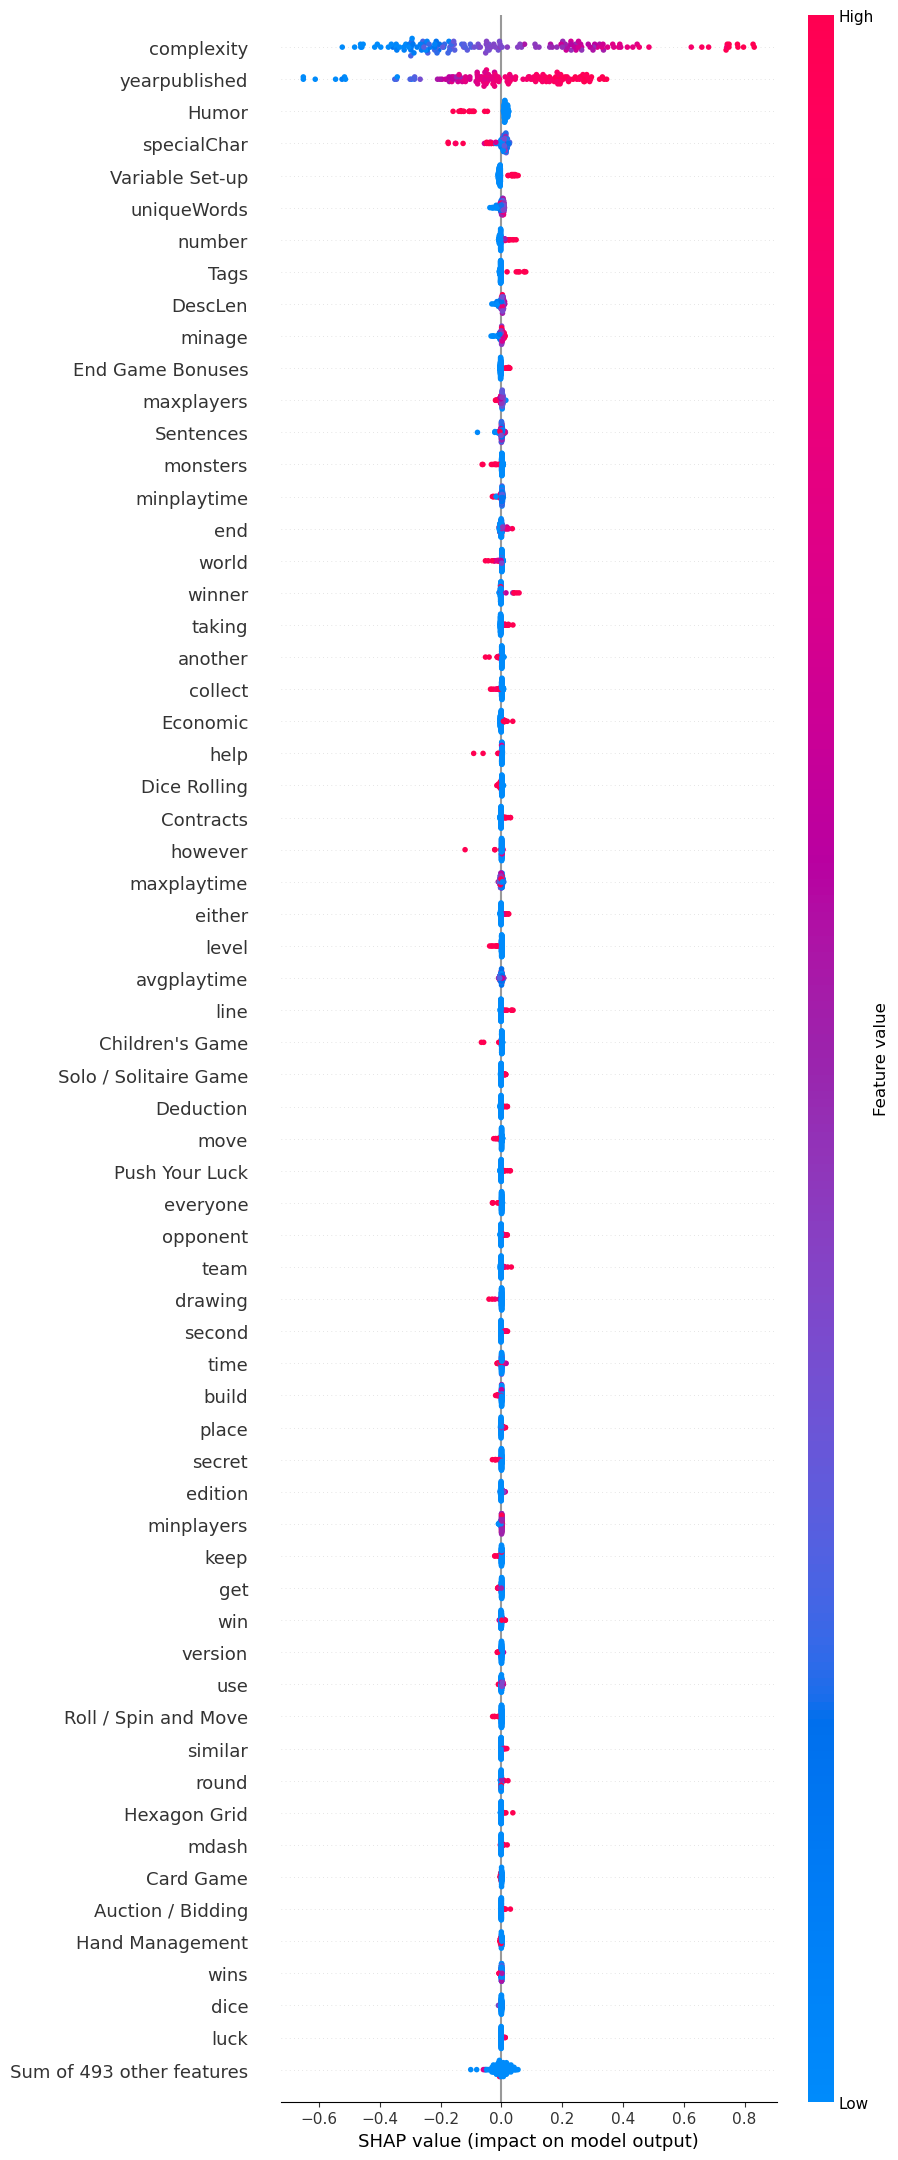

In [62]:
shap.plots.beeswarm(shap_values, show=True, color_bar=True, max_display=64)